Reading notch_io.txt...
Samples Read -> In: 2048, Out: 2047
Normalizing by Factor: 32768.0
Plots saved: 'notch_time_domain.png' and 'notch_freq_domain.png'


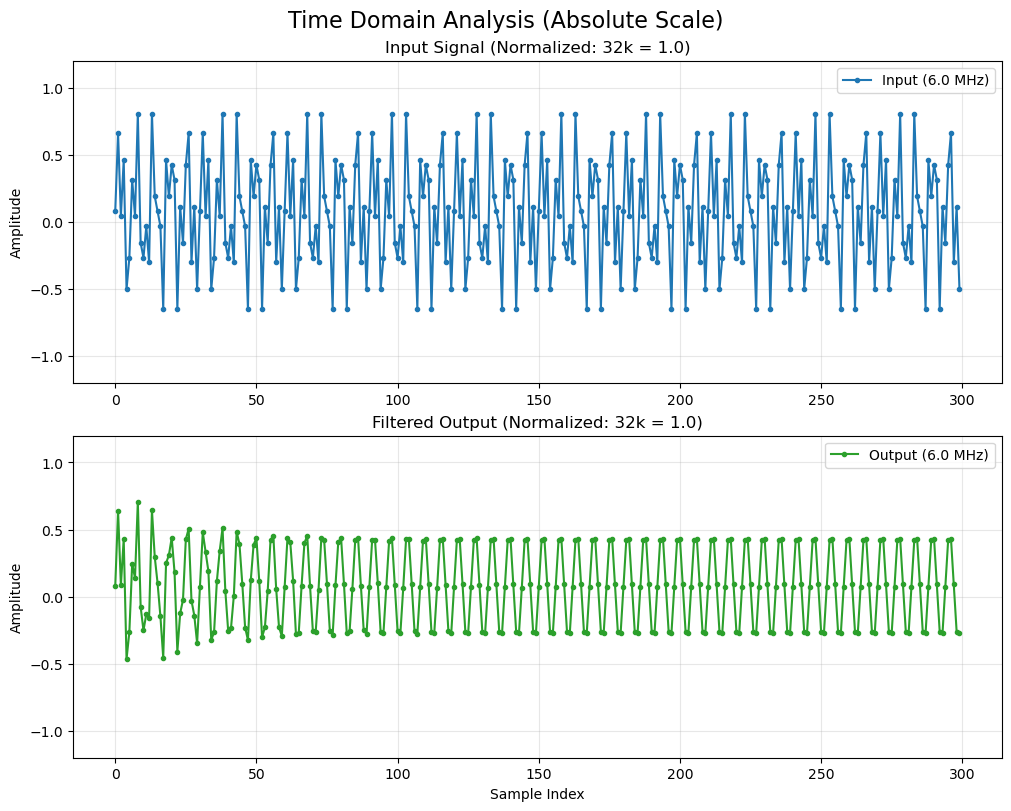

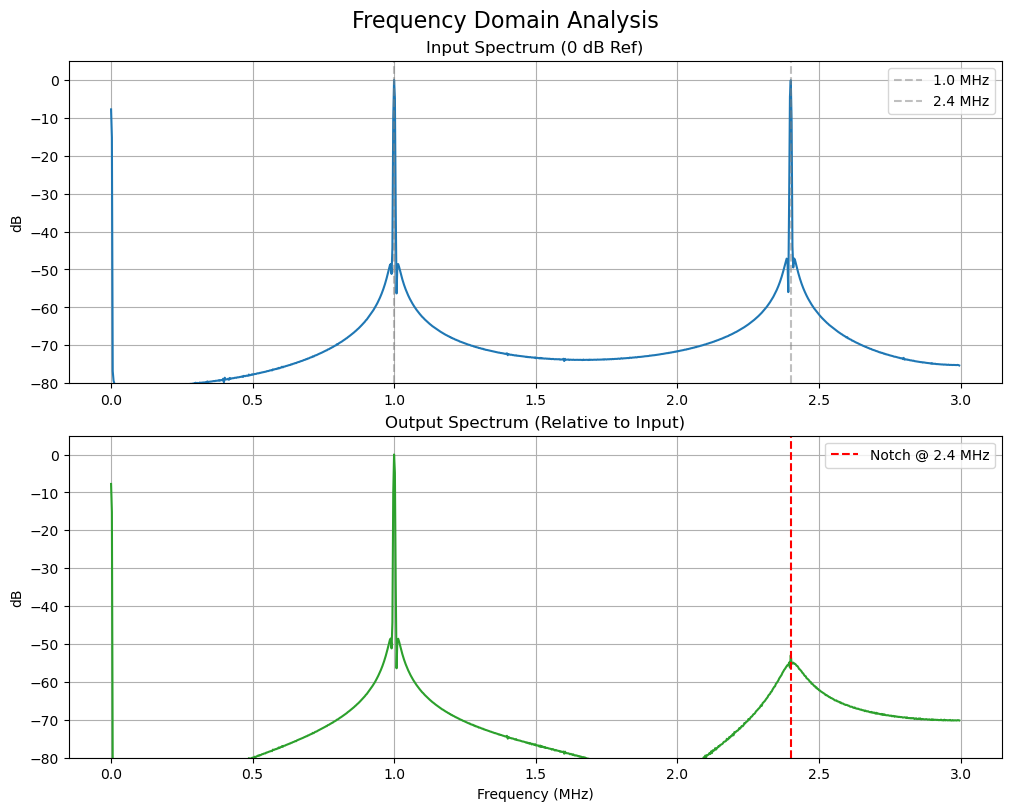

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import csv

# ==============================================================================
# Configuration
# ==============================================================================
FILENAME = "notch_io.txt"
FS = 6.0e6           # 6 MHz (Input and Output are same for Notch)
NORM_FACTOR = 32768.0 # Q1.15 Normalization (32768 = 1.0)

def parse_file(filename):
    """
    Reads the CSV generated by the SystemVerilog Testbench.
    Format: valid_i, data_i, valid_o, data_o
    """
    data_in = []
    data_out = []

    print(f"Reading {filename}...")
    try:
        with open(filename, 'r') as f:
            reader = csv.reader(f, skipinitialspace=True)
            for row in reader:
                if len(row) < 4: continue
                
                v_in  = int(row[0])
                d_in  = int(row[1])
                v_out = int(row[2])
                d_out = int(row[3])
                
                if v_in: data_in.append(d_in)
                if v_out: data_out.append(d_out)

    except FileNotFoundError:
        print(f"Error: Could not find {filename}. Run the simulation first.")
        exit()

    return np.array(data_in), np.array(data_out)

def plot_time_domain(sig_in, sig_out):
    """
    Plots Input and Output signals in time domain with absolute amplitude scaling.
    """
    # Create 2 subplots sharing X axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)
    
    # 1. Input Plot
    ax1.plot(sig_in, '.-', color='tab:blue', label=f'Input ({FS/1e6} MHz)')
    ax1.set_title(f"Input Signal (Normalized: 32k = 1.0)")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="upper right")
    ax1.set_ylabel("Amplitude")
    ax1.set_ylim([-1.2, 1.2]) 

    # 2. Output Plot
    ax2.plot(sig_out, '.-', color='tab:green', label=f'Output ({FS/1e6} MHz)')
    ax2.set_title(f"Filtered Output (Normalized: 32k = 1.0)")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper right")
    ax2.set_ylabel("Amplitude")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylim([-1.2, 1.2]) 

    plt.suptitle("Time Domain Analysis (Absolute Scale)", fontsize=16)
    plt.savefig('notch_time_domain.png')

def plot_frequency_domain(sig_in, sig_out):
    """
    Plots FFTs normalized to the Input's peak.
    """
    def get_fft_db(sig, fs):
        # Apply window to reduce spectral leakage
        window = np.hamming(len(sig))
        sig_windowed = sig * window
        
        # Compute FFT
        fft_val = np.fft.fft(sig_windowed)
        fft_freq = np.fft.fftfreq(len(sig), 1/fs)
        
        # Keep positive half
        half_n = len(sig) // 2
        fft_val = fft_val[:half_n]
        fft_freq = fft_freq[:half_n]
        
        # dB Calculation
        mag = 20 * np.log10(np.abs(fft_val) + 1e-12)
        return fft_freq, mag

    # Calculate FFTs
    f_in, mag_in = get_fft_db(sig_in, FS)
    f_out, mag_out = get_fft_db(sig_out, FS)
    
    # Normalize Spectrum Plots to the INPUT's peak (0 dB reference)
    ref_level = np.max(mag_in)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

    # 1. Input Spectrum
    ax1.plot(f_in/1e6, mag_in - ref_level, color='tab:blue')
    ax1.set_title(f"Input Spectrum (0 dB Ref)")
    ax1.set_ylabel("dB")
    ax1.grid(True)
    ax1.set_ylim(bottom=-80, top=5)
    
    # Markers for expected tones
    ax1.axvline(1.0, color='gray', linestyle='--', alpha=0.5, label='1.0 MHz')
    ax1.axvline(2.4, color='gray', linestyle='--', alpha=0.5, label='2.4 MHz')
    ax1.legend(loc='upper right')

    # 2. Output Spectrum
    ax2.plot(f_out/1e6, mag_out - ref_level, color='tab:green')
    ax2.set_title(f"Output Spectrum (Relative to Input)")
    ax2.set_xlabel("Frequency (MHz)")
    ax2.set_ylabel("dB")
    ax2.grid(True)
    ax2.set_ylim(bottom=-80, top=5)

    # Highlight the Notch
    ax2.axvline(2.4, color='red', linestyle='--', label='Notch @ 2.4 MHz')
    ax2.legend(loc='upper right')

    plt.suptitle("Frequency Domain Analysis", fontsize=16)
    plt.savefig('notch_freq_domain.png')

# --- Main Execution ---
if __name__ == "__main__":
    s_in_raw, s_out_raw = parse_file(FILENAME)
    
    print(f"Samples Read -> In: {len(s_in_raw)}, Out: {len(s_out_raw)}")

    if len(s_in_raw) > 0:
        # Match lengths for plotting
        min_len = min(len(s_in_raw), len(s_out_raw))
        s_in_raw = s_in_raw[:min_len]
        s_out_raw = s_out_raw[:min_len]

        print(f"Normalizing by Factor: {NORM_FACTOR}")
        s_in = s_in_raw / NORM_FACTOR
        s_out = s_out_raw / NORM_FACTOR

        # Plot first 300 samples for Time Domain visibility
        plot_time_domain(s_in[:300], s_out[:300]) 
        
        # Plot full signal for Frequency Domain resolution
        plot_frequency_domain(s_in, s_out)
        
        print("Plots saved: 'notch_time_domain.png' and 'notch_freq_domain.png'")
        # plt.show() # Uncomment to view window




In [2]:
import numpy as np
from scipy.signal import firwin

def generate_hex_coefficients():
    # Configuration
    num_taps = 128
    cutoff_frac = 1.0 / 3.0  # 1/3 of Nyquist frequency
    
    # 1. Design Filter (Windowed Sinc, Hamming window)
    # firwin arguments: num_taps, cutoff (normalized 0.0-1.0 where 1.0 is Nyquist)
    h = firwin(num_taps, cutoff_frac, window='hamming')

    # 2. Scale for Fixed Point Unity Gain
    # In Q15 fixed point, 1.0 is represented by 32768 (or 32767).
    # We scale so the Sum of Coefficients = 32768.
    # This ensures that DC signals (Gain) pass through with a magnitude of 1.0 (in fixed point math).
    target_gain = 32768.0 
    
    current_sum = np.sum(h)
    h_scaled = h * (target_gain / current_sum)
    
    # 3. Quantize to Integers
    h_quantized = np.round(h_scaled).astype(int)
    
    # 4. Correct Summation Error
    # Quantization often results in a sum that is slightly off (e.g., 32767 or 32769)
    # We adjust the center tap to ensure the sum is exactly 32768.
    current_q_sum = np.sum(h_quantized)
    diff = int(target_gain) - current_q_sum
    center_index = num_taps // 2
    h_quantized[center_index] += diff
    
    # 5. Format to Hex
    # We use 16-bit 2's complement hex (e.g., -1 is FFFF)
    hex_lines = []
    for val in h_quantized:
        # Mask with 0xFFFF to handle negative numbers correctly
        hex_val = f"{val & 0xFFFF:04X}" 
        hex_lines.append(hex_val)
        
    return hex_lines

if __name__ == "__main__":
    hex_values = generate_hex_coefficients()
    
    # Output to console (or redirect to file)
    print("\n".join(hex_values))
    print(f"\nTotal Coefficients: {len(hex_values)}")



FFF9
0007
000E
0007
FFF8
FFEF
FFF7
000A
0016
000C
FFF3
FFE3
FFF0
0012
0027
0016
FFE8
FFCC
FFE3
001F
0045
0026
FFD7
FFA7
FFCF
0035
0072
003E
FFBD
FF70
FFB2
0054
00B5
0061
FF98
FF20
FF87
0081
0116
0095
FF60
FEA8
FF47
00C7
01AD
00E7
FF06
FDE4
FEDB
013F
02B8
017E
FE5C
FC5B
FDF7
024D
0543
030F
FC5C
F70D
FA39
081E
1B1E
28B9
28B3
1B1E
081E
FA39
F70D
FC5C
030F
0543
024D
FDF7
FC5B
FE5C
017E
02B8
013F
FEDB
FDE4
FF06
00E7
01AD
00C7
FF47
FEA8
FF60
0095
0116
0081
FF87
FF20
FF98
0061
00B5
0054
FFB2
FF70
FFBD
003E
0072
0035
FFCF
FFA7
FFD7
0026
0045
001F
FFE3
FFCC
FFE8
0016
0027
0012
FFF0
FFE3
FFF3
000C
0016
000A
FFF7
FFEF
FFF8
0007
000E
0007
FFF9

Total Coefficients: 128


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Configuration matches your VHDL/SV testbench
FILENAME = "resampler_output.txt"
FS_IN = 9.0e6       # 9 MHz Input
L = 2
M = 3
FS_MID = FS_IN * L  # 18 MHz
FS_OUT = FS_MID / M # 6 MHz

# HARDCODED NORMALIZATION
NORM_FACTOR = 30000.0

def parse_file(filename):
    data_in = []
    data_mid = []
    data_out = []

    print(f"Reading {filename}...")
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith("IN:"):
                    val = int(line.split()[-1])
                    data_in.append(val)
                elif line.startswith("MID:"):
                    val = int(line.split()[-1])
                    data_mid.append(val)
                elif line.startswith("OUT:"):
                    val = int(line.split()[-1])
                    data_out.append(val)
    except FileNotFoundError:
        print(f"Error: Could not find {filename}. Run the simulation first.")
        exit()

    return np.array(data_in), np.array(data_mid), np.array(data_out)

def plot_time_domain(sig_in, sig_mid, sig_out):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)
    
    # 1. Input Plot
    ax1.plot(sig_in, '.-', color='tab:blue', label=f'Input ({FS_IN/1e6} MHz)')
    ax1.set_title(f"Input Signal (Normalized: 30k = 1.0)")
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc="upper right")
    ax1.set_ylabel("Amplitude")
    # Fixed Y limits to show range clearly
    ax1.set_ylim([-1.2, 1.2]) 

    # 2. Intermediate Plot
    ax2.plot(sig_mid, '.-', color='tab:orange', label=f'Upsampled x2 ({FS_MID/1e6} MHz)')
    ax2.set_title(f"Intermediate Signal (Normalized: 30k = 1.0)")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="upper right")
    ax2.set_ylabel("Amplitude")
    ax2.set_ylim([-1.2, 1.2]) 

    # 3. Output Plot
    ax3.plot(sig_out, '.-', color='tab:green', label=f'Output /3 ({FS_OUT/1e6} MHz)')
    ax3.set_title(f"Final Output (Normalized: 30k = 1.0)")
    ax3.grid(True, alpha=0.3)
    ax3.legend(loc="upper right")
    ax3.set_ylabel("Amplitude")
    ax3.set_xlabel("Sample Index")
    ax3.set_ylim([-1.2, 1.2]) 

    plt.suptitle("Time Domain Analysis (Absolute Scale)", fontsize=16)

def plot_frequency_domain(sig_in, sig_mid, sig_out):
    
    def get_fft_db(sig, fs):
        window = np.hamming(len(sig))
        sig_windowed = sig * window
        fft_val = np.fft.fft(sig_windowed)
        fft_freq = np.fft.fftfreq(len(sig), 1/fs)
        
        half_n = len(sig) // 2
        fft_val = fft_val[:half_n]
        fft_freq = fft_freq[:half_n]
        
        # dB Calculation
        mag = 20 * np.log10(np.abs(fft_val) + 1e-12)
        return fft_freq, mag

    # Calculate FFTs
    f_in, mag_in = get_fft_db(sig_in, FS_IN)
    f_mid, mag_mid = get_fft_db(sig_mid, FS_MID)
    f_out, mag_out = get_fft_db(sig_out, FS_OUT)
    
    # Normalize Spectrum Plots to the INPUT's peak
    # This preserves the gain relationships between stages
    ref_level = np.max(mag_in)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), constrained_layout=True)

    ax1.plot(f_in/1e6, mag_in - ref_level, color='tab:blue')
    ax1.set_title(f"Input Spectrum (0 dB Ref)")
    ax1.set_ylabel("dB")
    ax1.grid(True)
    ax1.set_ylim(bottom=-80, top=5)

    ax2.plot(f_mid/1e6, mag_mid - ref_level, color='tab:orange')
    ax2.set_title(f"Upsampled Spectrum (Relative to Input)")
    ax2.set_ylabel("dB")
    ax2.grid(True)
    ax2.set_ylim(bottom=-80, top=5)

    ax3.plot(f_out/1e6, mag_out - ref_level, color='tab:green')
    ax3.set_title(f"Output Spectrum (Relative to Input)")
    ax3.set_xlabel("Frequency (MHz)")
    ax3.set_ylabel("dB")
    ax3.grid(True)
    ax3.set_ylim(bottom=-80, top=5)

    plt.suptitle("Frequency Domain Analysis", fontsize=16)

# --- Main Execution ---
if __name__ == "__main__":
    s_in_raw, s_mid_raw, s_out_raw = parse_file(FILENAME)
    
    print(f"Samples Read -> In: {len(s_in_raw)}, Mid: {len(s_mid_raw)}, Out: {len(s_out_raw)}")

    if len(s_in_raw) > 0:
        print(f"Normalizing all signals by Fixed Factor: {NORM_FACTOR}")

        # --- FIXED NORMALIZATION ---
        s_in = s_in_raw / NORM_FACTOR
        s_mid = s_mid_raw / NORM_FACTOR
        s_out = s_out_raw / NORM_FACTOR

        plot_time_domain(s_in[:200], s_mid[:400], s_out[:150]) 
        plot_frequency_domain(s_in, s_mid, s_out)
        
        plt.show()



Reading resampler_output.txt...
Error: Could not find resampler_output.txt. Run the simulation first.
Samples Read -> In: 0, Mid: 0, Out: 0


: 